In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import os

from utils import *
from PATH import *
from data import *
from train_mult import *
from models import *

from torchinfo import summary

C:\Users\24488\Desktop\StudyUmich\EECS442\EECS442-final-project\dep-est\models.py:249: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color="black")


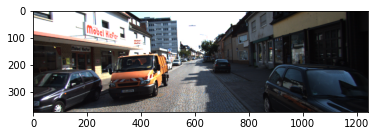

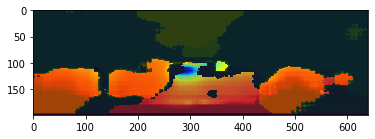

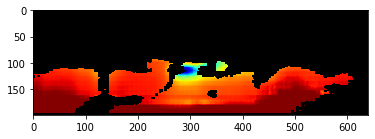

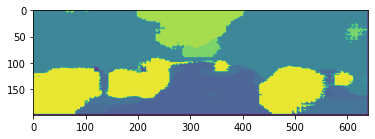

In [2]:
model_path, img_path = os.path.join("train-history", "trained_model99.pth"), "example1.png"

model = torch.load(model_path)
model.eval()
model = model.cpu()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize( (200, 640) ),     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])    
reg_pred, seg_pred = model.showInference(img_path, "train-history", preprocess, 1)

In [20]:
def colNum2X(x, L):
    C_X = 0
    ALPHA = 1000
    FOCAL_LENGTH = 0.001
    
    x_hat = (x - C_X) / ALPHA
    l = (x_hat**2 + FOCAL_LENGTH**2)**(0.5)
    X = x_hat / l * L
    Z  = FOCAL_LENGTH / l * L
    
    return X

def colNum2Z(x, L):
    C_X = 0
    ALPHA = 1000
    FOCAL_LENGTH = 0.001
    
    x_hat = (x - C_X) / ALPHA
    l = (x_hat**2 + FOCAL_LENGTH**2)**(0.5)
    X = x_hat / l * L
    Z  = FOCAL_LENGTH / l * L
    
    return Z

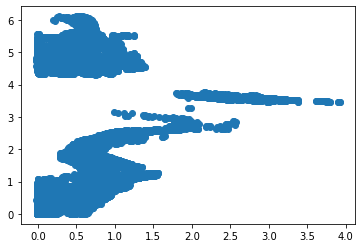

In [27]:
reg_pred26 = reg_pred.clone()
reg_pred26[seg_pred != 26] = 0


# Xs = [colNum2X(j, reg_pred26[i,j]) for i in range(reg_pred26.shape[0]) for j in range(reg_pred26.shape[1]) if reg_pred26[i,j] != 0]
# Zs = [colNum2Z(j, reg_pred26[i,j]) for i in range(reg_pred26.shape[0]) for j in range(reg_pred26.shape[1]) if reg_pred26[i,j] != 0]
Xs = [j / 100 for i in range(reg_pred26.shape[0]) for j in range(reg_pred26.shape[1]) if reg_pred26[i,j] != 0]
Zs = [reg_pred26[i,j] for i in range(reg_pred26.shape[0]) for j in range(reg_pred26.shape[1]) if reg_pred26[i,j] != 0]
segXs = [j / 100 for i in range(seg_pred.shape[0]) for j in range(seg_pred.shape[1]) if seg_pred[i,j] == 26]
segZs = [seg_pred[i,j] for i in range(seg_pred.shape[0]) for j in range(seg_pred.shape[1]) if seg_pred[i,j] == 26]
plt.figure()
plt.scatter(Zs, Xs)
# plt.scatter(segXs, segZs)